<a href="https://colab.research.google.com/github/wowser20/Color-Palette-Extraction-from-Images-Using-K-Means/blob/main/color_palette_extraction_from_images_using_k_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Discussion
**Color Palette Extraction from Images Using K-Means**


---



**Problem**




Choosing a color palette for your next design can be a daunting task. How can you make it easier? 
One approach is to go to a site where PROs share their work. Dribbble, uplabs, and Behance are good places to start.

After you've found some mockups you like, you might want to extract the colors from them and use them. This may necessitate the use of specialized software, manual color selection with some tool(s), and other over-the-counter hacks. 

This time let's put K-Means Clustering in action to make this task easier.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Data/Images

The images that i've used in extracting color palettes can be accessed and downloaded using this [link.](https://drive.google.com/drive/folders/1MYTqJ3X4ZkOMGwK6l-sg6MVVYKXnULp9?usp=sharing)


In [ ]:
from math import sqrt
import random
try:
  import Image
except ImportError:
  from PIL import Image

This time, our data doesn’t come from some predefined or well-known dataset. Since Unsupervised learning does not require labeled data. Here I'll use images that I've edited using photoshop. Our model will run on each shot and try to extract the color palette for each.

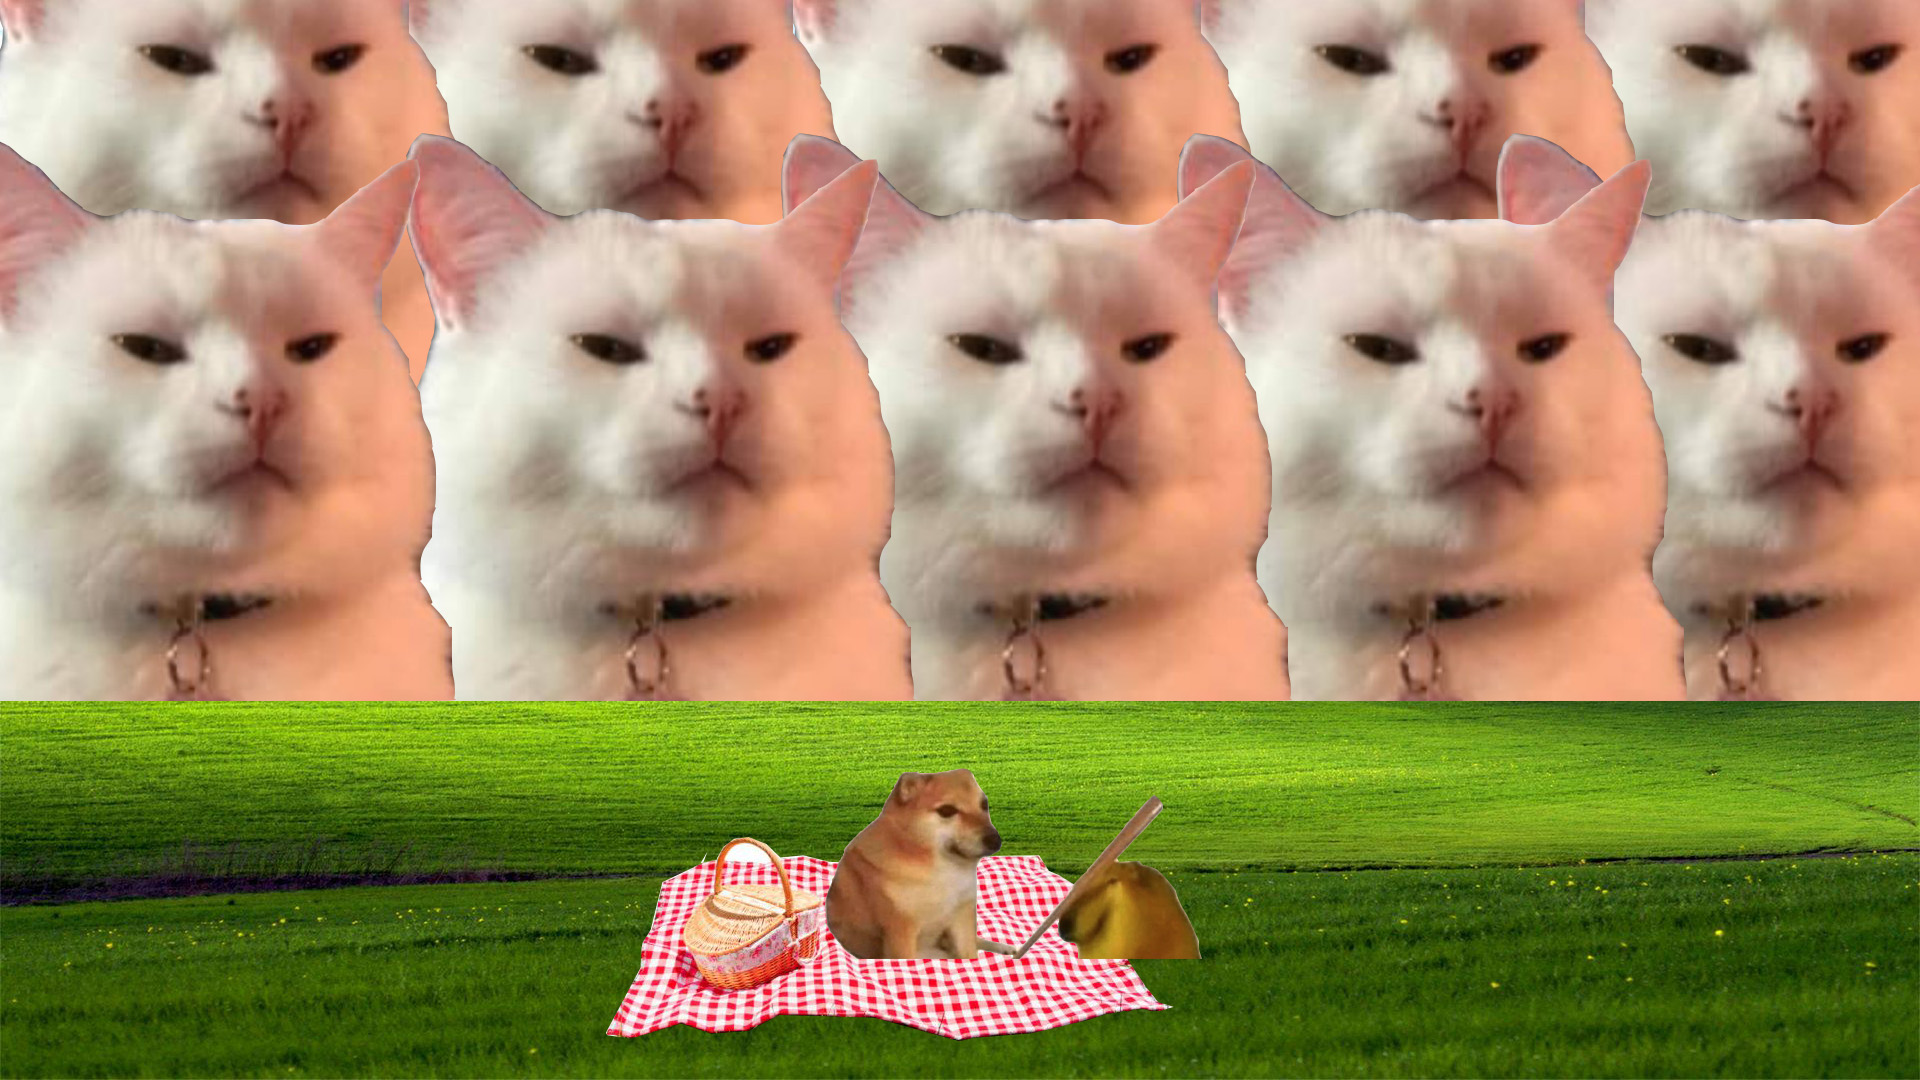

In [ ]:
from IPython.display import Image as CImage
CImage("/content/drive/MyDrive/ColorPalette/edit2.png", width=350, height=700)

# **Data Preprocessing**
Given that our data is stored in raw pixels (referred to as images), we must convert it to points that our clustering algorithm can use.

Let’s first define two classes that represent a point and cluster:

In [ ]:
class Point:
  
  def __init__(self, coordinates):
    self.coordinates = coordinates

Our Point is just a holder to the coordinates for each dimension in our space.

In [ ]:
class Cluster:
  
  def __init__(self, center, points):
    self.center = center
    self.points = points

The Cluster is defined by its center and all other points it contains.

Given a path to image file we can create the points as follows:

In [ ]:
def get_points(image_path):
  img = Image.open(image_path)
  img.thumbnail((200, 400))
  img = img.convert("RGB")
  w, h = img.size
  points = []
  for count, color in img.getcolors(w * h):
    for _ in range(count):
      points.append(Point(color))
  return points

A couple of things are happening here:

load the image into memory
resize it to smaller image 
drop the alpha (transparency) information
note that we’re creating a Point for each pixel in our image.

Alright! You can now extract points from an image. But how can we calculate the distance between points in our clusters?

**Euclidean distance**


---

Similar to the cost function in our supervised algorithm examples, we need a function that tells us how well we’re doing. The objective of our algorithm is to minimize the distance between the points in each centroid.

One of the simplest distance functions we can use is the Euclidean distance, defined by:

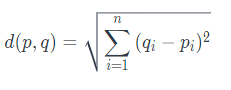
 

where p and q are two points from our space.

Note that while Euclidean distance is simple to implement it might not be the best way to calculate the color difference.

Here is the implementation:



In [ ]:
def euclidean(p, q):
  n_dim = len(p.coordinates)
  return sqrt(sum([
      (p.coordinates[i] - q.coordinates[i]) ** 2 for i in range(n_dim)
  ]))

# K-Means Clustering

Now that you have all pieces of the puzzle you can implement the K-Means clustering algorithm. 

Let’s start with the method that finds the center for a set of points,

Then followed by finding the center of a set of points, we add the values for each dimension and divide by the number of points.

The implementation follows the description of the algorithm given above. Note that we exit the training loop when the color difference is lower than the one set by us.

In [ ]:
class KMeans:
  
  def __init__(self, n_clusters, min_diff = 1):
    self.n_clusters = n_clusters
    self.min_diff = min_diff
    
  def calculate_center(self, points):    
    n_dim = len(points[0].coordinates)    
    vals = [0.0 for i in range(n_dim)]    
    for p in points:
      for i in range(n_dim):
        vals[i] += p.coordinates[i]
    coords = [(v / len(points)) for v in vals]    
    return Point(coords)
  
  def assign_points(self, clusters, points):
    plists = [[] for i in range(self.n_clusters)]

    for p in points:
      smallest_distance = float('inf')

      for i in range(self.n_clusters):
        distance = euclidean(p, clusters[i].center)
        if distance < smallest_distance:
          smallest_distance = distance
          idx = i

      plists[idx].append(p)
    
    return plists
    
  def fit(self, points):
    clusters = [Cluster(center=p, points=[p]) for p in random.sample(points, self.n_clusters)]
    
    while True:

      plists = self.assign_points(clusters, points)

      diff = 0

      for i in range(self.n_clusters):
        if not plists[i]:
          continue
        old = clusters[i]
        center = self.calculate_center(plists[i])
        new = Cluster(center, plists[i])
        clusters[i] = new
        diff = max(diff, euclidean(old.center, new.center))

      if diff < self.min_diff:
        break

    return clusters

Now that you have an implementation of K-Means clustering you can use it on the images. We need a little more glue code to make it easier to extract color palettes:

In [ ]:
def rgb_to_hex(rgb):
  return '#%s' % ''.join(('%02x' % p for p in rgb))
def get_colors(filename, n_colors=3):
  points = get_points(filename)
  clusters = KMeans(n_clusters=n_colors).fit(points)
  clusters.sort(key=lambda c: len(c.points), reverse = True)
  rgbs = [map(int, c.center.coordinates) for c in clusters]
  return list(map(rgb_to_hex, rgbs))

The get_colors function takes a path to an image file and the number of colors you want to extract from the image. We sort the clusters obtained from our algorithm based on the points in each (in descending order). Finally, we convert the RGB colors to hexadecimal values.


In [ ]:
colors = get_colors('/content/drive/MyDrive/ColorPalette/edit2.png', n_colors=5)

The code below only visualizes the extracted color palette from the image as a grid which is shown in the results.

In [ ]:
import seaborn as sns

sns.set()

def hex_to_rgb(hex_value):
  h = hex_value.lstrip('#')
  return tuple(int(h[i:i + 2], 16) / 255.0 for i in (0, 2, 4))

hex_colors = colors

rgb_colors = list(map(hex_to_rgb, hex_colors))

# Result
and here are the hexadecimal color palette and codes extracted from the image.

'#d19a83, #3a500d, #dccec2, #986956, #77a11c'

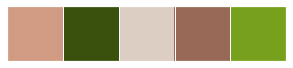

In [ ]:

sns.palplot(rgb_colors)

", ".join(colors)

# Conclusion
**Solution**





K-means clustering is a method for partitioning a set of data points into several disjoint subsets, with the points in each subset deemed to be 'close' to each other (according to some metric). The euclidean distance function is a common metric, at least when the points can be represented geometrically. The 'k' simply refers to the number of subsets that should be included in the final output. This approach turns out to be exactly what we need to extract color palettes from images.


Using k-means to generate palettes based on images is simple and it quickly gets you a basic set of colors to work with your next design compared to manual color palette extraction methods.

**References:**

X. Lewis, “Extracting colours from an image using K-means clustering,” Medium, 29-May-2021. [Online]. Available: https://towardsdatascience.com/extracting-colours-from-an-image-using-k-means-clustering-9616348712be. [Accessed: 06-Oct-2022]. 

M. Vanga, “Image-based palettes using K-means clustering,” Sighack, 03-Feb-2018. [Online]. Available: https://sighack.com/post/image-based-palettes-using-k-means-clustering. [Accessed: 06-Oct-2022]. 